# 311 NYC Service Request Analysis and Time Series Forecasting

# Installing important libraries required for the Analysis

In [23]:
#------------------------------------------------------
# Some important libraries to download for Analysis----
#------------------------------------------------------
!pip install plotly.express
!pip install scipy
!pip install seaborn
!pip install fbprophet
!pip install pystan
!pip install pmdarima
!pip install sklearn
!pip install statsmodels

# Importing libraries required for Analysis

In [1]:
#-----------------------------
# Importing Analysis libraries
#-----------------------------
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')
import scipy.stats as ss 
from datetime import datetime
import requests
import calendar

#----------------------------------
# Importing Visualisation libraries
#----------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

In [2]:
#----------------------------------------------
# Importing 311 NYC Service Request data as CSV
#----------------------------------------------
nycservice = pd.read_csv('/Users/prabavmurali/Downloads/311_data.csv')
nycservice

unique_key             created_date agency       complaint_type  \
0          32310161  2016-01-01T00:00:00.000  DOHMH               Rodent   
1          32310287  2016-01-01T00:00:00.000  DOHMH               Rodent   
2          32310788  2016-01-01T00:00:00.000  DOHMH               Rodent   
3          32310789  2016-01-01T00:00:00.000  DOHMH               Rodent   
4          32310790  2016-01-01T00:00:00.000  DOHMH               Rodent   
...             ...                      ...    ...                  ...   
2391383    35137497  2016-12-31T23:58:26.000   NYPD     Derelict Vehicle   
2391384    35142668  2016-12-31T23:58:52.000   NYPD  Noise - Residential   
2391385    35143535  2016-12-31T23:59:02.000    HPD       HEAT/HOT WATER   
2391386    35138369  2016-12-31T23:59:21.000   NYPD     Blocked Driveway   
2391387    35140259  2016-12-31T23:59:31.000   NYPD      Illegal Parking   

                      location_type incident_zip    borough  
0                        Vacant Lot        10473      BRONX  
1             Other (Explain Below)        10468      BRONX  
2           3+ Family Apt. Building        10029  MANHATTAN  
3           3+ Family Apt. Building        11432     QUEENS  
4           3+ Family Apt. Building        11210   BROOKLYN  
...                             ...          ...        ...  
2391383             Street/Sidewalk      10009.0  MANHATTAN  
2391384  Residential Building/House      10463.0      BRONX  
2391385        RESIDENTIAL BUILDING      11225.0   BROOKLYN  
2391386             Street/Sidewalk      11213.0   BROOKLYN  
2391387             Street/Sidewalk      11230.0   BROOKLYN  

[2391388 rows x 7 columns]

# Performing EDA (Exploratory Data Analysis)

In [3]:
#------------------------------------------
# Performing a Pandas Profiling on the data
#------------------------------------------
profile = ProfileReport(nycservice, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
#---------------------------------------
# Importing the weather datasets as CSVs
#---------------------------------------
os.chdir("/Users/prabavmurali/Downloads/weather/")
weather_desc = pd.read_csv('weather_description.csv')
cityatt = pd.read_csv('city_attributes.csv')
humid = pd.read_csv('humidity.csv')
pressure = pd.read_csv('pressure.csv')
temperature = pd.read_csv('temperature.csv')
winddir = pd.read_csv('wind_direction.csv')
windspeed = pd.read_csv('wind_speed.csv')

In [5]:
#-------------------------------------------------
# Checking for Null Values in the 311 service data
#-------------------------------------------------
nycservice.isna().sum()

unique_key             0
created_date           0
agency                 0
complaint_type         0
location_type     563548
incident_zip      133193
borough                0
dtype: int64

In [6]:
#----------------------------------------------------------
# Getting some information about the dataframe using info()
#----------------------------------------------------------
nycservice.info()
print('-----------------------------------------------------------------------------------')
print('Number of rows and columns in the data as (RowCount,ColumnCount):',nycservice.shape)
print('-----------------------------------------------------------------------------------')
nycservice['created_date'] = pd.to_datetime(nycservice['created_date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2391388 entries, 0 to 2391387
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   unique_key      int64 
 1   created_date    object
 2   agency          object
 3   complaint_type  object
 4   location_type   object
 5   incident_zip    object
 6   borough         object
dtypes: int64(1), object(6)
memory usage: 127.7+ MB
-----------------------------------------------------------------------------------
Number of rows and columns in the data as (RowCount,ColumnCount): (2391388, 7)
-----------------------------------------------------------------------------------


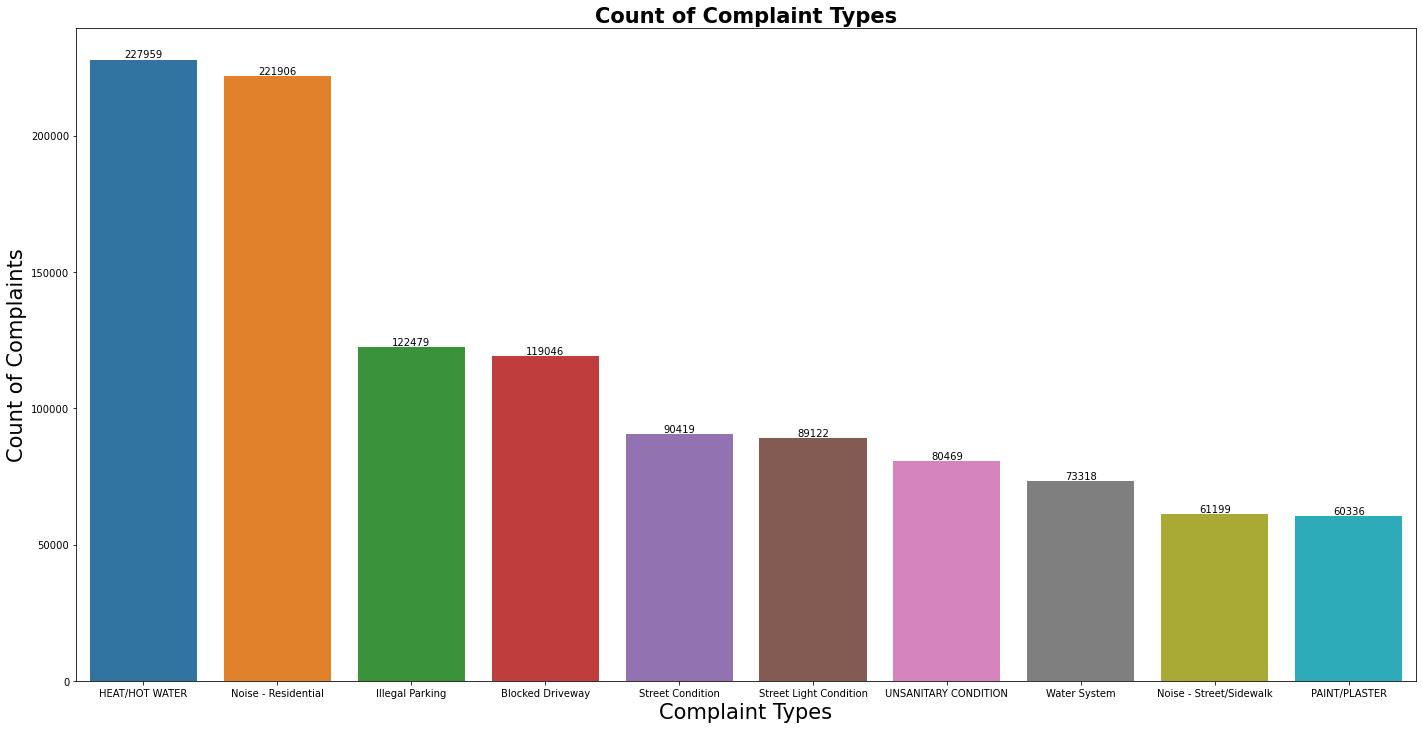

In [7]:
#------------------------------------------
# Visualising the data for gaining insights
#------------------------------------------
plt.gcf().set_size_inches(24, 12)
ax = sns.countplot(x="complaint_type", data=nycservice, order=pd.value_counts(
    nycservice['complaint_type']).iloc[:10].index)
ax.set_title('Count of Complaint Types', fontsize=21, fontweight='bold', color='black')
ax.set_xlabel('Complaint Types', fontsize=21, color='black')
ax.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax.containers:
    ax.bar_label(container)
#------------------------------------------------------
# TOTAL COMPLAINTS RECEIVED BY COMPLAINT TYPES
# Heat/hot water complaint was the most received at 311
#------------------------------------------------------

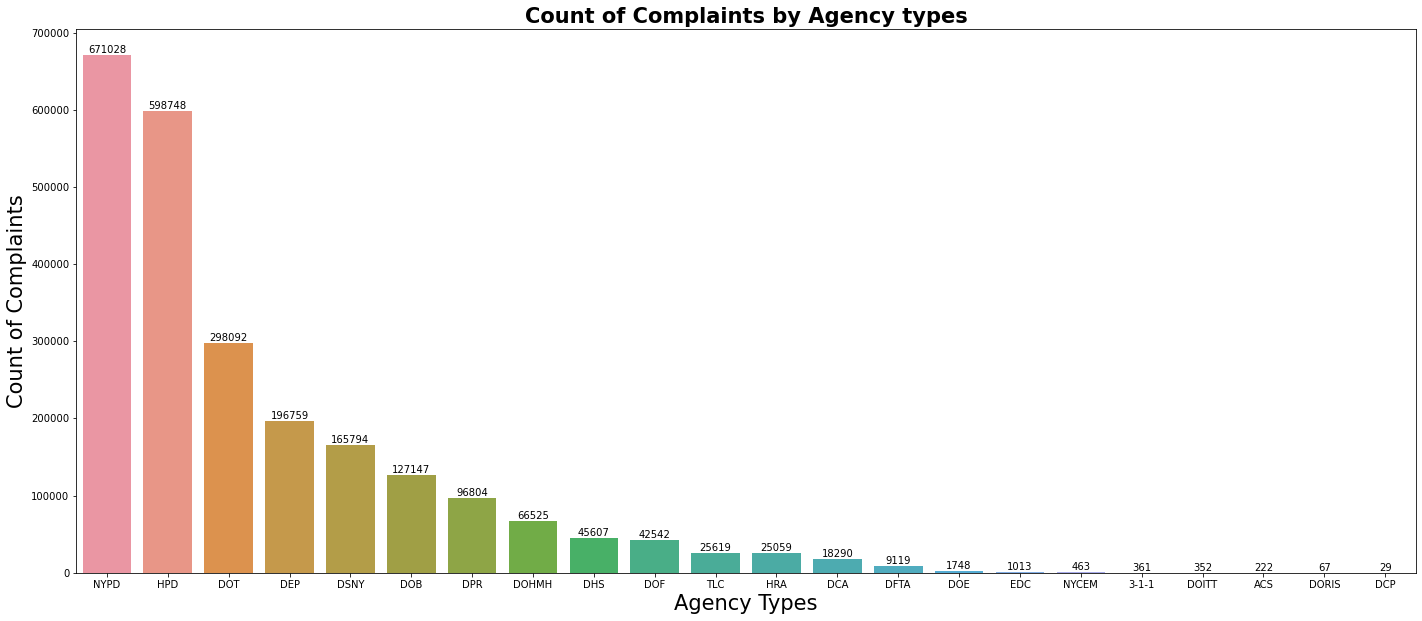

In [8]:
plt.gcf().set_size_inches(24, 10)
ax1 = sns.countplot(x="agency", data=nycservice, order=pd.value_counts(nycservice['agency']).index)
ax1.set_title('Count of Complaints by Agency types', fontsize=21, fontweight='bold', color='black')
ax1.set_xlabel('Agency Types', fontsize=21, color='black')
ax1.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax1.containers:
    ax1.bar_label(container)
#---------------------------------------------    
#New York Police Department got the most calls
#---------------------------------------------

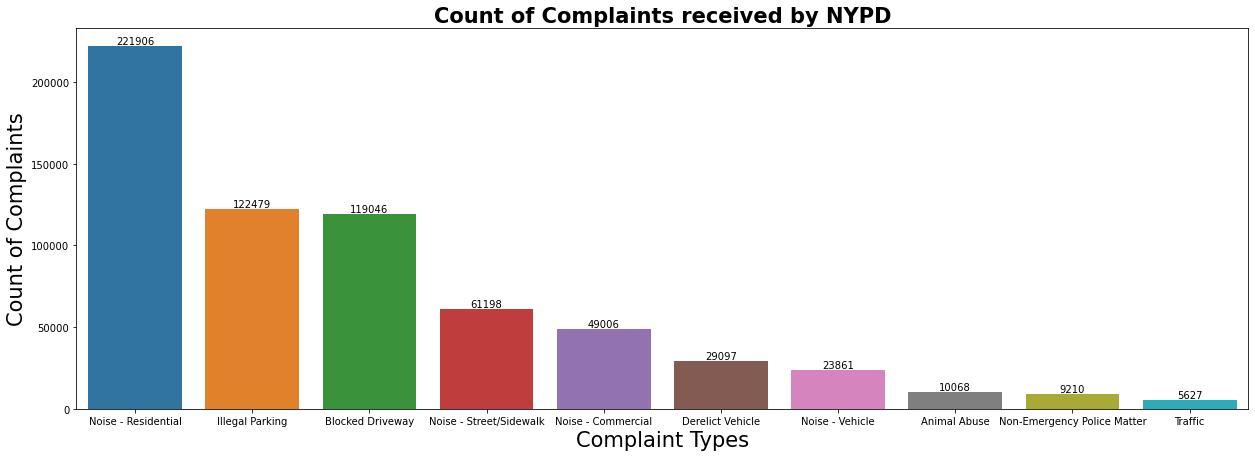

In [9]:
#-----------------------------------
#Let us see NYPD's complaint types..
#-----------------------------------
nypdcomplaint = nycservice[nycservice['agency']=='NYPD']
plt.gcf().set_size_inches(21, 7)
ax2 = sns.countplot(x="complaint_type", data=nypdcomplaint, order=pd.value_counts(
    nypdcomplaint['complaint_type']).head(n=10).index)
ax2.set_title('Count of Complaints received by NYPD', fontsize=21, fontweight='bold', color='black')
ax2.set_xlabel('Complaint Types', fontsize=21, color='black')
ax2.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax2.containers:
    ax2.bar_label(container)
#---------------------------------------------------------------------------------------------
# The below chart shows us that the top complaint type received by NYPD is Noise - Residential
#---------------------------------------------------------------------------------------------

The Borough names are:  ['BRONX' 'BROOKLYN' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND']
Enter the name of the Borough to view the call count: BROOKLYN


Please select the BOROUGHS Available from the List


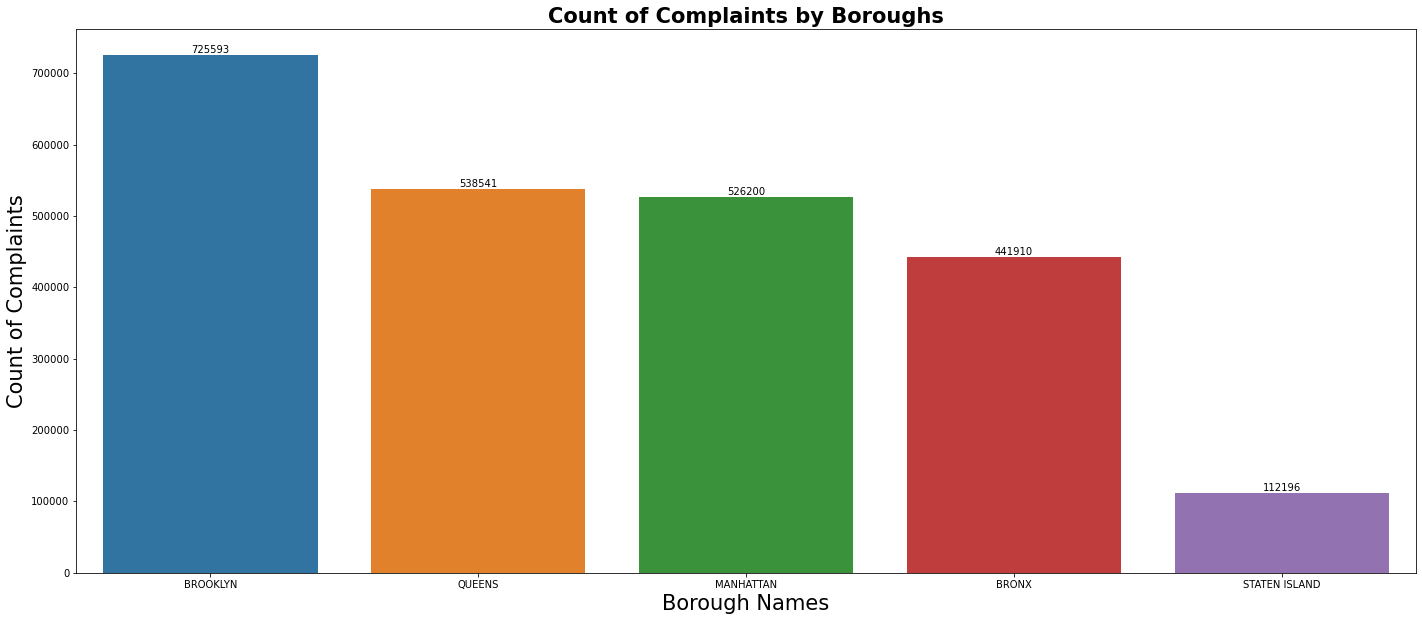

In [10]:
import plotly.graph_objects as go
plt.gcf().set_size_inches(24, 10)
nycborough = nycservice[nycservice['borough'] != 'Unspecified']
nycborough
ax4 = sns.countplot(x="borough", data=nycborough, order=pd.value_counts(nycborough['borough']).index)
ax4.set_title('Count of Complaints by Boroughs', fontsize=21, fontweight='bold', color='black')
ax4.set_xlabel('Borough Names', fontsize=21, color='black')
ax4.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax4.containers:
    ax4.bar_label(container)
boroughcount = nycborough.groupby('borough')['unique_key'].count().to_frame().reset_index().rename(
    {'unique_key':'Count'}, axis=1)

print('The Borough names are: ', boroughcount['borough'].values)
boroughname = input('Enter the name of the Borough to view the call count: ')

def boroughcomplaints(boroughname):
    boroughlist = list(boroughcount['borough'])
    complaintcount = list(boroughcount['Count'])
    n=max(complaintcount)
    countval = float(boroughcount['Count'][(boroughcount['borough']== boroughname)].values)
    fig = go.Figure(go.Indicator(
        domain = {'x': [0, 1], 'y': [0, 1]},
        value = countval,
        mode = "gauge+number",
        title = {'text': f"Number of Calls received from {boroughname} in Millions"},
        gauge = {'axis': {'range': [None, 2000000]},'steps' : [{'range': [0, 600000], 'color': "#7CCD7C"},{
            'range':[600000, 1600000], 'color': "#CDCD00"},{'range': [1600000,2000000 ], 'color': "#FF7256"}],'threshold' : {'line': {'color': "#CD0000", 'width': 7}, 'thickness': 0.75, 'value': 1600000}}))
    pyo.iplot(fig.show())

try:
    boroughcomplaints(boroughname)
except:
    print('Please select the BOROUGHS Available from the List')

#-----------------------------------------------------------------------------------------------------
# Let us see each Borough's complaint count in the year 2016 (in Millions)
# Please enter a valid Input from the list to view the count of complaints from the particular Borough
#-----------------------------------------------------------------------------------------------------

In [11]:
#-----------------------------------------------------------------------------------------------------
#From the previous Gauge Chart, we can infer that BROOKLYN borough produced more calls (0.726 million)
#Let us check what complaint type has been more in Brooklyn as focus
#-----------------------------------------------------------------------------------------------------
a = nycborough.groupby(['borough', 'complaint_type'])['unique_key'].agg('count').groupby(level=0).nlargest(3).to_frame().reset_index(drop=True,level=1).reset_index()

fig = px.sunburst(a, path=['borough', 'complaint_type', 'unique_key'], values='unique_key', template='plotly_dark', title="EACH BOROUGH's TOP 3 COMPLAINTS")
fig.show()
#---------------------------------------------------------------------
# THE BELOW CHART DEPICTS EACH BOROUGH's TOP 3 REPORTED COMPLAINTS
# FOCUSING ON BROOKLYN HEAT/HOT WATER HAS BEEN THE PROBLEM IN BROOKLYN
#---------------------------------------------------------------------

In [12]:
#--------------------------------------------------------------------------------------------
# Extracting only the Date, Month and Year from the created_date column available as Timestamp
#--------------------------------------------------------------------------------------------
nycservice['DateOnly'] = nycservice['created_date'].apply(lambda x: x.date())
nycservice

unique_key        created_date agency       complaint_type  \
0          32310161 2016-01-01 00:00:00  DOHMH               Rodent   
1          32310287 2016-01-01 00:00:00  DOHMH               Rodent   
2          32310788 2016-01-01 00:00:00  DOHMH               Rodent   
3          32310789 2016-01-01 00:00:00  DOHMH               Rodent   
4          32310790 2016-01-01 00:00:00  DOHMH               Rodent   
...             ...                 ...    ...                  ...   
2391383    35137497 2016-12-31 23:58:26   NYPD     Derelict Vehicle   
2391384    35142668 2016-12-31 23:58:52   NYPD  Noise - Residential   
2391385    35143535 2016-12-31 23:59:02    HPD       HEAT/HOT WATER   
2391386    35138369 2016-12-31 23:59:21   NYPD     Blocked Driveway   
2391387    35140259 2016-12-31 23:59:31   NYPD      Illegal Parking   

                      location_type incident_zip    borough    DateOnly  
0                        Vacant Lot        10473      BRONX  2016-01-01  
1             Other (Explain Below)        10468      BRONX  2016-01-01  
2           3+ Family Apt. Building        10029  MANHATTAN  2016-01-01  
3           3+ Family Apt. Building        11432     QUEENS  2016-01-01  
4           3+ Family Apt. Building        11210   BROOKLYN  2016-01-01  
...                             ...          ...        ...         ...  
2391383             Street/Sidewalk      10009.0  MANHATTAN  2016-12-31  
2391384  Residential Building/House      10463.0      BRONX  2016-12-31  
2391385        RESIDENTIAL BUILDING      11225.0   BROOKLYN  2016-12-31  
2391386             Street/Sidewalk      11213.0   BROOKLYN  2016-12-31  
2391387             Street/Sidewalk      11230.0   BROOKLYN  2016-12-31  

[2391388 rows x 8 columns]

In [13]:
count = nycservice.groupby('DateOnly')['unique_key'].count().to_frame().reset_index().rename(
    {'unique_key':'Count of calls each day'}, axis=1).sort_values(
    by='Count of calls each day', ascending=False).reset_index(drop=True)
count
#---------------------------------------------------------------------------
# We can see the number of calls received by 311 for the entire year of 2016
#---------------------------------------------------------------------------

DateOnly  Count of calls each day
0    2016-01-05                    12035
1    2016-01-19                    10376
2    2016-02-14                     9920
3    2016-12-16                     9659
4    2016-11-21                     9484
..          ...                      ...
361  2016-12-26                     4172
362  2016-11-24                     4049
363  2016-12-24                     3974
364  2016-12-25                     3584
365  2016-11-06                     3412

[366 rows x 2 columns]

In [14]:
nytemperature = temperature.iloc[:,[0,28]]
nytemperature['datetime'] = nytemperature['datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())

nytemperature['New York'] = nytemperature['New York'].apply(lambda x:x-273.15)
# Converted the Temperature from Kelvin to Celsius----

nytemperature = nytemperature.rename({'New York':'NY Celsius'}, axis=1).dropna()
nytemperature = nytemperature.groupby('datetime')['NY Celsius'].agg('mean').round().to_frame().reset_index()
nytemperature
#-----------------------------------------------------------------------------------------------------------------
# Considering only New York & converting the New York temperatures from Kelvin to Celsius for better understanding
# We have the Temperature (in Celsius) data from 2012-2017
#-----------------------------------------------------------------------------------------------------------------

datetime  NY Celsius
0     2012-10-01        15.0
1     2012-10-02        18.0
2     2012-10-03        17.0
3     2012-10-04        19.0
4     2012-10-05        21.0
...          ...         ...
1849  2017-10-24        21.0
1850  2017-10-25        17.0
1851  2017-10-26        13.0
1852  2017-10-27        11.0
1853  2017-10-28        12.0

[1854 rows x 2 columns]

In [15]:
nywindspeed = windspeed.iloc[:,[0,28]]
nywindspeed['datetime'] = nywindspeed['datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
nywindspeed = nywindspeed.rename({'New York': 'NY Wind Speed'}, axis=1).dropna()
nywindspeed = nywindspeed.groupby('datetime')['NY Wind Speed'].max().to_frame().reset_index()
nywindspeed
#-------------------------------------------
# We have the wind speed data from 2012-2017
#-------------------------------------------

datetime  NY Wind Speed
0     2012-10-01            7.0
1     2012-10-02            6.0
2     2012-10-03            5.0
3     2012-10-04            3.0
4     2012-10-05            4.0
...          ...            ...
1849  2017-10-24           10.0
1850  2017-10-25            6.0
1851  2017-10-26            4.0
1852  2017-10-27            3.0
1853  2017-10-28            2.0

[1854 rows x 2 columns]

In [16]:
nyhumidity = humid.iloc[:,[0,28]]
nyhumidity['datetime'] = nyhumidity['datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
nyhumidity = nyhumidity.rename({'New York': 'NY Humidity'}, axis=1).dropna()
nyhumidity = nyhumidity.groupby('datetime')['NY Humidity'].mean().to_frame().reset_index()
nyhumidity
#-----------------------------------------
# We have the humidity data from 2012-2017
#-----------------------------------------

datetime  NY Humidity
0     2012-10-01    56.272727
1     2012-10-02    50.950000
2     2012-10-03    68.541667
3     2012-10-04    94.545455
4     2012-10-05    93.041667
...          ...          ...
1849  2017-10-24    83.000000
1850  2017-10-25    73.208333
1851  2017-10-26    54.125000
1852  2017-10-27    51.625000
1853  2017-10-28    58.000000

[1854 rows x 2 columns]

In [17]:
#-------------------------------------------------------------------------------------------
# Let us see what were the complaints related to when the temperature fell below 0 Celsius..
#-------------------------------------------------------------------------------------------
nytempfreeze = nytemperature[nytemperature['NY Celsius']<0]
nytempfreeze = pd.merge(nytempfreeze, nycservice, left_on='datetime', right_on='DateOnly', how='inner')
nytempfreeze = nytempfreeze.groupby('complaint_type')['unique_key'].count().to_frame().reset_index()
nytempfreeze = nytempfreeze.sort_values(by='unique_key', ascending=False).nlargest(12, 'unique_key').rename(
    {'unique_key':'Count of complaints'}, axis=1)
fig = px.pie(nytempfreeze, values='Count of complaints', names='complaint_type', hole=0.6, template='plotly_dark' ,title='Percentage of Complaints when Temperature dropped below 0°C Celsius')
fig.show()

In [18]:
merg = pd.merge(nytemperature, count, left_on='datetime', right_on='DateOnly', how='inner').drop(
    columns='DateOnly', axis=1).rename({"datetime":'Date Of Year'}, axis=1)
merg = pd.merge(merg, nywindspeed, left_on='Date Of Year', right_on='datetime', how='inner').drop('datetime',axis=1)
merg = pd.merge(merg, nyhumidity, left_on='Date Of Year', right_on='datetime', how='inner').drop('datetime',axis=1)
merg['Date Of Year'] = pd.to_datetime(merg['Date Of Year'])
merg['Day Number'] = merg['Date Of Year'].dt.weekday
merg['Day Name'] = merg['Day Number'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',
                                                5:'Saturday',6:'Sunday'})
merg.to_csv('/Users/prabavmurali/Desktop/merged.csv')
merg
#---------------------------------------------------------
# The merged dataset will be used for the further analysis
#---------------------------------------------------------

Date Of Year  NY Celsius  Count of calls each day  NY Wind Speed  \
0     2016-01-01         4.0                     4315            8.0   
1     2016-01-02         2.0                     4569            7.0   
2     2016-01-03         2.0                     4806            7.0   
3     2016-01-04        -1.0                     8988            9.0   
4     2016-01-05        -8.0                    12035           10.0   
..           ...         ...                      ...            ...   
361   2016-12-27        11.0                     6249            9.0   
362   2016-12-28         4.0                     6903            5.0   
363   2016-12-29         1.0                     6327            4.0   
364   2016-12-30         2.0                     6075            7.0   
365   2016-12-31         1.0                     4227            7.0   

     NY Humidity  Day Number   Day Name  
0      61.125000           4     Friday  
1      56.875000           5   Saturday  
2      62.458333           6     Sunday  
3      50.583333           0     Monday  
4      42.125000           1    Tuesday  
..           ...         ...        ...  
361    76.958333           1    Tuesday  
362    56.791667           2  Wednesday  
363    77.500000           3   Thursday  
364    64.000000           4     Friday  
365    62.958333           5   Saturday  

[366 rows x 7 columns]

In [19]:
###################################################################################################
# Some of the Visualisations are based on plotly charts. Please run the cell to visualise the chart 
# or Click "Trust" Notebook to see the results..
###################################################################################################

In [20]:
#---------------------------------------------
# Now let us see some important visualisations
# Count of calls everyday in the year 2016
#---------------------------------------------
abc = px.line(merg, x=merg['Date Of Year'], y=merg['Count of calls each day'], template='plotly_dark', width=1100)
pyo.iplot(abc)
#The below line chart depicts Count of calls received every day in 2016

In [21]:
#--------------------------------------------
# Temperature everyday in the year 2016
#--------------------------------------------
pyo.iplot(px.line(merg, x=merg['Date Of Year'], y=merg['NY Celsius'], template='plotly_dark', width=1100))
#----------------------------------------------------------------------
#The below line chart depicts Count of calls received every day in 2016
#----------------------------------------------------------------------

In [22]:
#--------------------------------------------
# Wind Speed everyday in the year 2016
#--------------------------------------------
pyo.iplot(px.line(merg, x=merg['Date Of Year'], y=merg['NY Wind Speed'], template='plotly_dark', width=1100))

In [23]:
#---------------------------------------------------------------------------------
#Let us see the count of calls each month in 2016
#---------------------------------------------------------------------------------
month_dict = {'January':1,'February':2,'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
merg1 = merg.groupby(merg['Date Of Year'].dt.strftime('%B'))['Count of calls each day'].sum().to_frame().sort_values(
    'Date Of Year', key = lambda x : x.apply (lambda x : month_dict[x])).reset_index().rename(
    {'Date Of Year':'Month Of Year','Count of calls each day':'Count of calls each month'}, axis=1)
merg1
#---------------------------------------------------------------------------------
#January shows most calls received. Let us visualize it as a circular bar chart..
#---------------------------------------------------------------------------------

Month Of Year  Count of calls each month
0        January                     211474
1       February                     198427
2          March                     196968
3          April                     186106
4            May                     202393
5           June                     208524
6           July                     203504
7         August                     202213
8      September                     189380
9        October                     199363
10      November                     189023
11      December                     204013

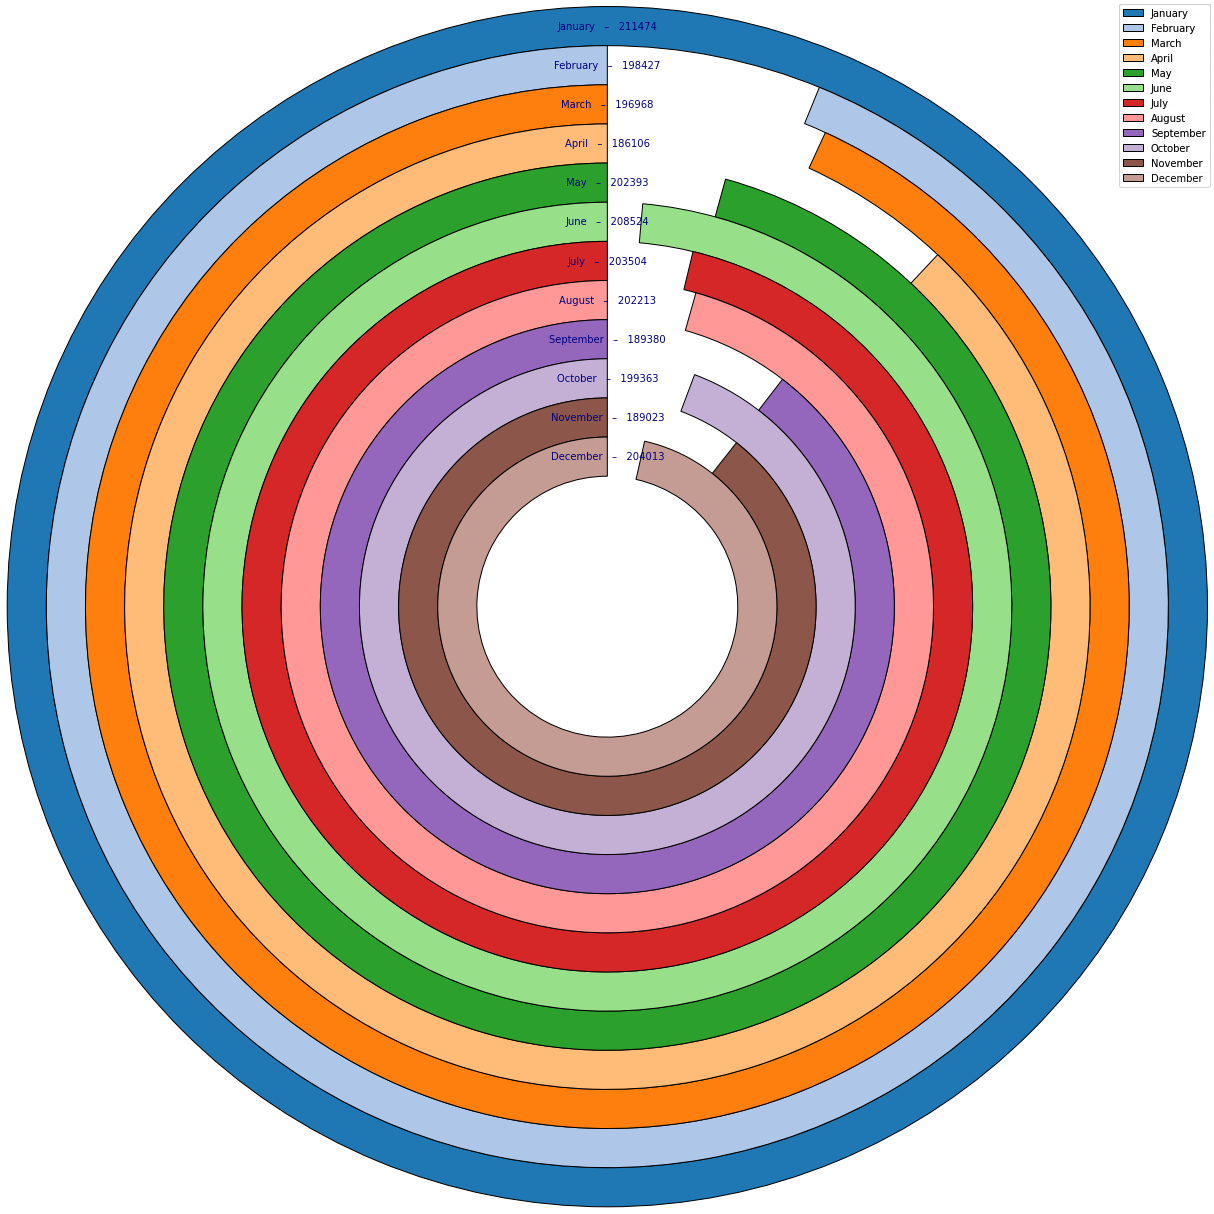

In [24]:
labels = list(merg1['Month Of Year'])
data = list(merg1['Count of calls each month'])
n = len(data)
rad = 6.9
rad_inner = 1.5
width = (rad - rad_inner) / n
colors = plt.cm.tab20.colors
fig, ax = plt.subplots()
ax.axis("equal")

for i in range(n):
    radius = rad -i*width
    ax.pie([data[i]/max(data)], radius=radius, startangle=90,
           counterclock=True, colors=[colors[i]], normalize=False,
           wedgeprops={'width': width, 'edgecolor': 'black'}, )
    ax.text(0, radius - width / 2, f'{labels[i]}   –   {data[i]}', ha='center', va='center', color='navy')
    fig.legend(merg1['Month Of Year'], loc=1)
plt.show()
#--------------------------------------------------------------------
#The below circular bar chart shows that January had the most calls..
#--------------------------------------------------------------------

In [25]:
#--------------------------------------------------------------------------------------------------------
# Let us see which which day of the week received calls frequently
#--------------------------------------------------------------------------------------------------------
day_dict = {'Monday':0,'Tuesday':1,'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
dayname = merg.groupby('Day Name')['Count of calls each day'].sum().to_frame().sort_values(
    'Day Name', key = lambda x : x.apply (lambda x : day_dict[x])).reset_index()
dayname
#--------------------------------------------------------------------------------------------------------
# Tuesday received the most calls compared to any other day.. Let us visualise for better understanding..
#--------------------------------------------------------------------------------------------------------

Day Name  Count of calls each day
0     Monday                   367968
1    Tuesday                   386259
2  Wednesday                   368380
3   Thursday                   358275
4     Friday                   353587
5   Saturday                   289262
6     Sunday                   267657

In [26]:
#--------------------------------------------------------------------------------------------------------
# From the below bar chart Tuesday received the most calls compared to any other day with not much of a 
# difference though..
#---------------------------------------------------------------------------------------------------------------------------------------
pyo.iplot(px.bar(dayname, x=dayname['Day Name'], y=dayname['Count of calls each day'],color='Day Name', template='plotly_dark', width=1100))
#---------------------------------------------------------------------------------------------------------------------------------------
#From the below bar chart, we can infer that Tuesdays had the most number of calls in 2016 
#---------------------------------------------------------------------------------------------------------------------------------------

# Statistical Tests to check Correlation and Statistical Significance

In [27]:
#--------------------------------------------------------------------------------------------------------
# Let us check the correlation score of weather parameters like temperature with Count of calls each day
#--------------------------------------------------------------------------------------------------------
tempcorrelation = merg['NY Celsius'].corr(merg['Count of calls each day'])
windcorrelation = merg['NY Wind Speed'].corr(merg['Count of calls each day'])
humiditycorrelation = merg['NY Humidity'].corr(merg['Count of calls each day'])
tempcorrelation, windcorrelation, humiditycorrelation
#-------------------------------------------------------------------------------------------------------------
# Negative Correlation indicates that call count MIGHT INCREASE when temperature or humidity
# decreases..But it is a weak correlation as the value is 0.1. Strong correlation has to be atleast 0.7 to 0.8
# ---------------------------
# Wind speed and Count of calls have a positive correlation as well, but again it is a weak correlation
#-------------------------------------------------------------------------------------------------------------

(-0.11243168940157848, 0.10195505646965816, -0.11885610029406436)

In [28]:
#------------------------------------------------------------------------------------------------------
#Let us check for another test to check whether the negative and positive correlation had an impact on 
#count of calls or not by using t-test
#------------------------------------------------------------------------------------------------------
t_stat, p_val= ss.ttest_ind(merg['Count of calls each day'],merg['NY Celsius'])
t_stat , p_val
#-------------------------------------------------------------------------------------------
#As the p-value is less than 0.05 (5%), we can reject the Null Hypothesis..
#There is a statistical relationship between the two variables and impact is not by chance..
#-------------------------------------------------------------------------------------------

(107.4778383427754, 0.0)

# Implementing the Time Series Forecasting to forecast next day's calls

In [29]:
#----------------------------------------------------
# Importing the libraries for Time Series Forecasting
#----------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.api import qqplot
import statsmodels.tsa.api as tsa
import statsmodels.api as sm

In [30]:
#-----------------------------------------
#Converting the values to ARIMA standards
#-----------------------------------------
time = merg['Date Of Year'].value_counts()
volume = pd.DataFrame({'ds':merg['Date Of Year'], 'y':merg['Count of calls each day']})
volume.set_index(['ds'], inplace=True)

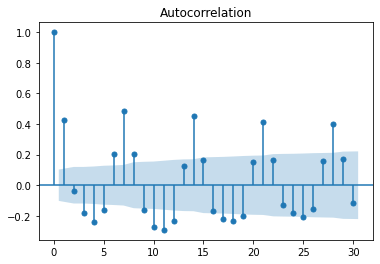

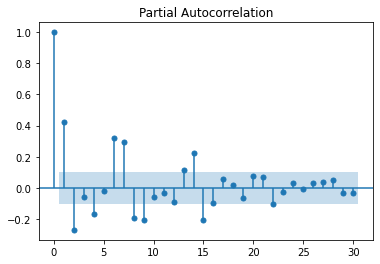

In [33]:
#--------------------------------------------------------------
#Checking for Autocorrelation and Partial Autocorrelation plots
#--------------------------------------------------------------
plot_acf(volume.y,lags=30)
plt.show()

plot_pacf(volume.y,lags=30)
plt.show()

<AxesSubplot:xlabel='ds'>

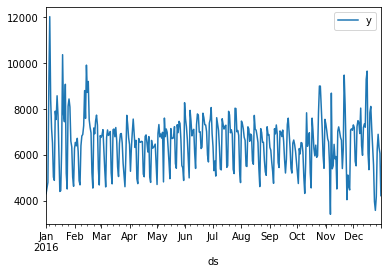

In [34]:
volume.plot()

In [35]:
from pmdarima.arima import ADFTest, auto_arima
adf_test= ADFTest(alpha = 0.05)
adf_test.should_diff(volume)
#-------------------------------------------------------------------------------------------------------------
#Proves that the data is stationary and there is no need of differencing which is implied by the value 'False'
#-------------------------------------------------------------------------------------------------------------

(0.01, False)

# Implementing ARIMA model

In [37]:
#-------------------------------------------------------------------------------------------------
# In order to make the model understand the data more, treating of outlier values becomes necessary
# Hence we are bringing the outlier values within the quantiles
#-------------------------------------------------------------------------------------------------
scaled_vol = volume.copy()
print(scaled_vol['y'].quantile(0.25)) 
print(scaled_vol['y'].quantile(0.955))
scaled_vol['y'] = np.where(scaled_vol['y'] > scaled_vol['y'].quantile(0.955), scaled_vol['y'].quantile(0.75), scaled_vol['y'])
scaled_vol['y'] = np.where(scaled_vol['y'] < scaled_vol['y'].quantile(0.25), scaled_vol['y'].quantile(0.25), scaled_vol['y'])
#------------------------------------------------------------------------------------------------
# Performing ARIMA based analysis for Time series forecasting
# Splitting the data as Training data and test data. Train data of 270 days is fed into the model
#------------------------------------------------------------------------------------------------
arima_model = auto_arima(scaled_vol.iloc[0:270], start_p=0,start_d=0,start_q=0,max_p=20,
max_d=20,max_q=20, start_P=0,start_Q=0, start_D=0,
max_P=20,max_Q=20, max_D=20, m=20, seasonal=False,
error_action='warn',trace = True,
supress_warnings=True, stepwise = True,
random_state=20,n_fits = 100)
#---------------------------------------------------
# Using Auto Arima for searching the best parameters
#---------------------------------------------------

5650.25
8365.674999999997
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5522.605, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5193.797, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4340.064, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4383.427, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4281.815, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4274.518, Time=0.20 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, 

In [38]:
#--------------------------------------------------------------------------------------------
# Let us now forecast the values based on the training data using the model's best parameters
#--------------------------------------------------------------------------------------------
forecast = pd.DataFrame(arima_model.predict(n_periods=96,index=volume.iloc[270:]))
forecast.tail()

0
91  7357.597028
92  7227.710502
93  6920.351088
94  6566.740345
95  5921.937614

In [39]:
#--------------------------------------------------
#Adding the column 'Forecasted values' to the data
#--------------------------------------------------
forecast.columns = ['Forecasted Values']
forecast = forecast.set_index(merg['Date Of Year'].iloc[270:])

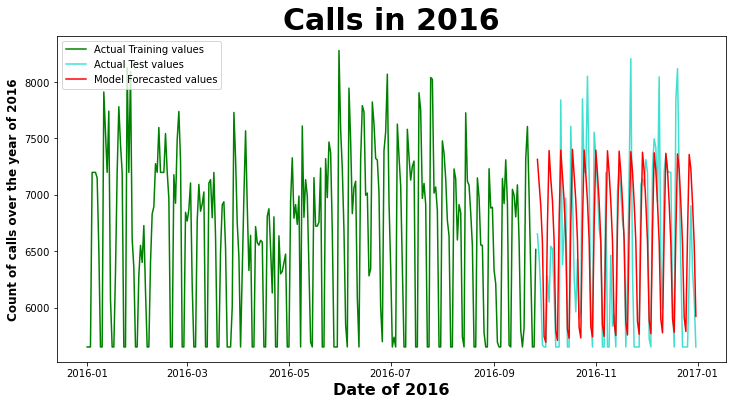

In [42]:
plt.figure(figsize=(12,6))
plt.plot(scaled_vol.iloc[0:270], color='green')
plt.plot(scaled_vol.iloc[270:], color='turquoise')
plt.plot(forecast, color='red')
plt.legend(['Actual Training values', 'Actual Test values', 'Model Forecasted values'])
plt.title('Calls in 2016', fontsize=30, fontweight='bold')
plt.xlabel('Date of 2016',fontsize=16, fontweight='bold')
plt.ylabel('Count of calls over the year of 2016', fontsize=12, fontweight='bold')
plt.show()

In [43]:
# Importing the evaluation metrics for the model
#-----------------------------------------------
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

test = volume.iloc[270:]
test['forecasted_values'] = forecast
print('Mean Absolute Percentage Error value for ARIMA is: ',mean_absolute_percentage_error(test['y'], test['forecasted_values'])*100)
print('Mean Absolute Error value for ARIMA is: ',mean_absolute_error(test['y'], test['forecasted_values']))

#------------------------------------------------------------------------------------------
# Seems the model has given good results. But we can improve the model prediction even more
# Let us try Facebook's Prophet model..
#------------------------------------------------------------------------------------------

Mean Absolute Percentage Error value for ARIMA is:  13.73299374236884
Mean Absolute Error value for ARIMA is:  796.1807293057864


# Implementing Prophet Model to forecast next day's value

In [44]:
volume1 = volume.copy()
volume['y_orig'] = volume['y'] #<------ Saving a copy of the original data
# Transform the 'y' variable by quantiles
#volume['y'] = np.log(volume['y']) <--- We can also use log to transform the variable
print(merg['Count of calls each day'].quantile(0.50)) 
print(merg['Count of calls each day'].quantile(0.955))
volume1['y'] = np.where(volume1['y'] > volume1['y'].quantile(0.955), volume1['y'].quantile(0.50), volume1['y'])
volume1.shape

6694.5
8365.674999999997


(366, 1)

In [62]:
#----------------------------------------------------------------------------------------------
# Importing the Prophet model and forecasting the values based on the training data of 280 days
#----------------------------------------------------------------------------------------------
from prophet import Prophet

m = Prophet()
m.fit(volume1.iloc[0:280].reset_index())
future = m.make_future_dataframe(periods=90)
future.tail()
forecast = m.predict(future)

#----------------------------------------------------------------------------
# Here the parameters are ds (Time), yhat(Predicted), yhat_lower- Lower bound of Confidence Interval,
# and yhat_upper is the upper bound of the confidence interval..
#----------------------------------------------------------------------------

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


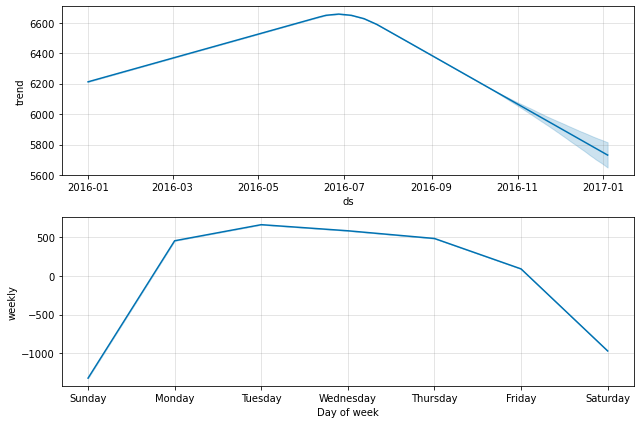

In [63]:
x = m.plot_components(forecast)
#----------------------------------------------------------------
# The below plot gives us the trend and weekly seasonality graphs
#----------------------------------------------------------------

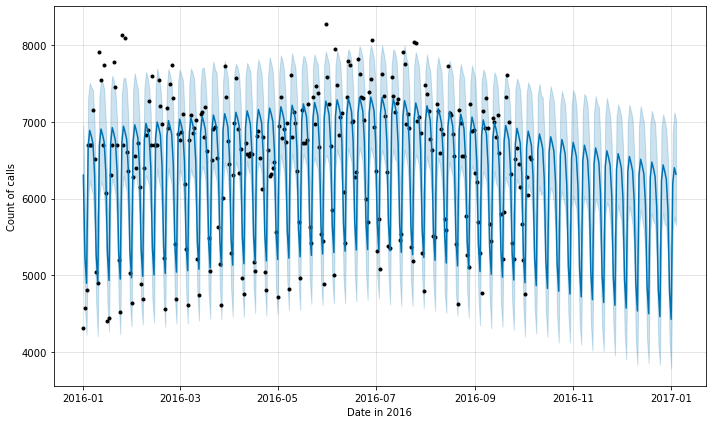

In [64]:
x = m.plot(forecast, xlabel='Date in 2016', ylabel='Count of calls')

#----------------------------------------------------------------------------------------------------------
# The black dots are the actual data points and Blue lines are the predictions with shaded regions are 
# the confidence intervals (uncertainty samples)
#----------------------------------------------------------------------------------------------------------

In [69]:
#----------------------------------------------------------------------------------------------
# Let us evaluate the model with Mean Absolute Percentage Error and Mean Absolute Error metrics
#----------------------------------------------------------------------------------------------
joined_df = volume.merge(forecast, left_on='ds', right_on='ds')
print('The Mean Absolute Percentage Error for Prophet model is',mean_absolute_percentage_error(joined_df.y, joined_df.yhat)*100)
print('The Mean Absolute Error for Prophet Model is',mean_absolute_error(joined_df.y, joined_df.yhat))
futureforecast = forecast[['ds','yhat','yhat_upper','yhat_lower']].tail(n=4)
futureforecast
#-------------------------------------------------------------------------------------------------------------------
# Prophet Model has performed the best among the 2 models for the 2016 data..
# The MAPE Percentage is 8.42% which is a better performing model for the given data and MAE also proves the same...
# The calls for the next day would be around 4425 which is shown below..
#-------------------------------------------------------------------------------------------------------------------

The Mean Absolute Percentage Error for Prophet model is 8.419992634539671
The Mean Absolute Error for Prophet Model is 563.5828283701089


ds         yhat   yhat_upper   yhat_lower
366 2017-01-01  4424.747216  5098.302735  3783.733055
367 2017-01-02  6198.491250  6867.005232  5584.838016
368 2017-01-03  6401.516204  7121.806419  5763.227697
369 2017-01-04  6317.255063  7037.117186  5651.056900